## Import the package into jupyter notebook

In [1]:
import numpy as np # linear algebra
import pandas as pd
from tqdm import tqdm
import os
#print(os.listdir("free-spoken-digit-dataset-master"))

In [2]:
# import package
import librosa
import os
from os.path import isdir, join
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.io import wavfile
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
#print(tf.__version__)

### Check the data

In [4]:
# find the dataset path, and listen to the voice
# data_path = 'free-spoken-digit-dataset-master/recordings/'
data_path = 'recordings/'
import IPython
filename='0_jackson_0.wav'
IPython.display.Audio(data_path+filename)

#### Everything is OK

In [5]:
# fistly, we check the shape of the wave
filename='0_jackson_0.wav'
wav, sr = librosa.load(data_path + filename)
print ('sr:', sr)
print ('wav shape:', wav.shape)
print ('length:', sr/wav.shape[0], 'secs')

sr: 22050
wav shape: (14190,)
length: 1.5539112050739958 secs


#### Plot actual sound

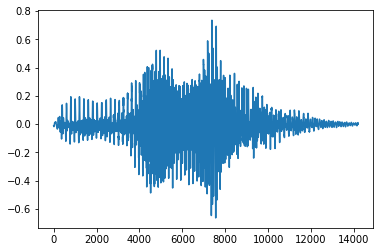

In [6]:
import matplotlib.pyplot as plt
plt.plot(wav)

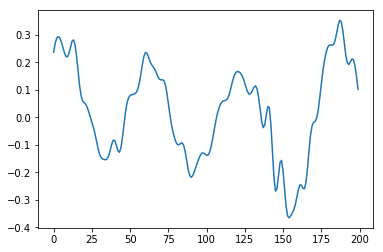

In [7]:
plt.plot(wav[4000:4200])

### Loading the data

In [8]:
def wav2mfcc(file_path, augment = False, max_pad_len=11):
    """
    return - all the data ans their labels
    """
    wave, sr = librosa.load(file_path, mono=True, sr=8000, duration = 1.024)
    
    if augment == True:
        bins_per_octave = 12
        pitch_pm = 4
        pitch_change =  pitch_pm * 2*(np.random.uniform())   
        wave = librosa.effects.pitch_shift(wave, 
                                          8000, n_steps=pitch_change, 
                                          bins_per_octave=bins_per_octave)
        
        speed_change = np.random.uniform(low=0.9,high=1.1)
        wave = librosa.effects.time_stretch(wave, speed_change)
        wave = wave[:8192]

    duration = wave.shape[0]/sr
    speed_change = 2.0* duration/1.024
    wave = librosa.effects.time_stretch(wave, speed_change)
    wave = wave[:4096]
    
    wave = librosa.util.normalize(wave)
    mfcc = librosa.feature.mfcc(wave, sr=sr, n_mfcc=40, hop_length=int(0.048*sr), n_fft=int(0.096*sr))
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    #print("shape=",mfcc.shape[1], wave.shape[0])
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    #mfcc = mfcc[2:24,:]
    return (mfcc, duration, sr)

def get_data(dir = '', augment= False):
    labels = []
    mfccs = []
    durations = []
    sampling_rates = []
    filenames = []

    for f in tqdm(os.listdir(dir)):
        if f.endswith('.wav'):
            mfcc, duration, sr = wav2mfcc(dir + "/" + f, augment)
            mfccs.append(mfcc)
            durations.append(duration)
            sampling_rates.append(sr)
            # List of labels
            label = f.split('_')[0]
            labels.append(label)
            filenames.append(dir + "/" + f)
    return (filenames, np.asarray(mfccs), np.asarray(durations), np.asarray(sampling_rates), 
            to_categorical(labels), labels)

In [9]:
filenames, mfccs, durations, sampling_rates, labels, cls_true = get_data('recordings/')


100%|██████████| 2000/2000 [02:16<00:00, 14.65it/s]


### Get all the data

In [10]:
def get_all():
    """
    get all the data and keep their construction
    """
    filenames, mfccs, durations, sampling_rates, labels, cls_true = get_data(data_path, augment = False)
    
    filenames_a, mfccs_a, durations_a, sampling_rates_a, labels_a, cls_true_a = get_data(data_path, augment = True)
    mfccs = np.append(mfccs, mfccs_a, axis=0)
    labels = np.append(labels, labels_a, axis =0)
    
    dim_1 = mfccs.shape[1]
    dim_2 = mfccs.shape[2]
    channels = 1
    classes = 10
    
    print("sampling rate (max) = ", np.max(sampling_rates))
    print("sampling rate (min) = ", np.min(sampling_rates))
    print("duration (max) = ", np.max(durations))
    print("duration (avg) = ", np.average(durations))
    print("duration (min) = ", np.min(durations))
    print("mffc matrix = ", mfccs.shape)
    X = mfccs
    X = X.reshape((mfccs.shape[0], dim_1, dim_2, channels))
    y = labels

    input_shape = (dim_1, dim_2, channels)

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    return X, y, input_shape

In [ ]:
### padding, we can still use padding, but here, we just pad when we load data
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#padded_waves = pad_sequences(all_waves, padding = 'post', truncating = 'post', maxlen = 10000)
#freqs,tims,spectros = get_spectrograms(padded_waves)
#spectros = np.array(spectros)
#spectros = spectros.reshape(2000,129,44,1)

In [11]:
X, y, input_shape = get_all()

100%|██████████| 2000/2000 [02:59<00:00, 11.17it/s]

sampling rate (max) =  8000
sampling rate (min) =  8000
duration (max) =  1.024
duration (avg) =  0.40094793749999996
duration (min) =  0.1435
mffc matrix =  (4000, 40, 11)


In [12]:
print ('input_shape:', input_shape)
print ('mfccs.shape:', X.shape)
print ('dim_1, dim_2, channels', input_shape)

input_shape: (40, 11, 1)
mfccs.shape: (4000, 40, 11, 1)
dim_1, dim_2, channels (40, 11, 1)


### Let us try other ways to keep the constrcution of the sound data

In [13]:
# we split data into training data and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
print(X_train.shape)
input_shape
num_classes = 10

(3200, 40, 11, 1)


## Build the model

In [17]:
# Build Model
model = tf.keras.models.Sequential()
# 1st Conv2D Layer
model.add(Conv2D(32,(5,5), activation='relu',padding='same', input_shape=input_shape))
model.add(Conv2D(32,(5,5), activation='relu',))
model.add(MaxPooling2D(2, 2))
model.add(Dropout((0.25)))
# 2nd Conv2D Layer
model.add(Conv2D(64, (3,3), activation='relu',padding='same'))
model.add(Conv2D(64, (3,3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
model.add(Dropout((0.25)))
# Fully-Connected Layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout((0.5)))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 40, 11, 32)        832       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 36, 7, 32)         25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 3, 32)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 18, 3, 32)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 3, 64)         18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 3, 64)         36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 1, 64)          0         
__________

In [18]:
# Compile Model
model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

## Train the data

In [28]:
batch_size = 128
num_epochs = 50

In [24]:
# Train Model
hisrtory = model.fit(X_train,Y_train,batch_size=batch_size,epochs=num_epochs,validation_data=(X_test,Y_test))

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 11s 3ms/sample - loss: 0.0458 - acc: 0.9859 - val_loss: 0.1365 - val_acc: 0.9787
Epoch 2/50
3200/3200 [==============================] - 11s 3ms/sample - loss: 0.0431 - acc: 0.9909 - val_loss: 0.1787 - val_acc: 0.9688
Epoch 3/50
3200/3200 [==============================] - 11s 3ms/sample - loss: 0.0468 - acc: 0.9894 - val_loss: 0.1943 - val_acc: 0.9650
Epoch 4/50
3200/3200 [==============================] - 11s 3ms/sample - loss: 0.0298 - acc: 0.9919 - val_loss: 0.1805 - val_acc: 0.9737
Epoch 5/50
3200/3200 [==============================] - 11s 3ms/sample - loss: 0.0572 - acc: 0.9856 - val_loss: 0.1747 - val_acc: 0.9675
Epoch 6/50
3200/3200 [==============================] - 11s 3ms/sample - loss: 0.0463 - acc: 0.9887 - val_loss: 0.1637 - val_acc: 0.9737
Epoch 7/50
3200/3200 [==============================] - 11s 3ms/sample - loss: 0.0286 - acc: 0.9919 - val_loss: 0.1673 - val_acc: 0

### plot the accuracy

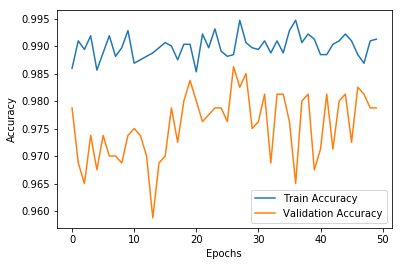

In [26]:
plt.plot(hisrtory.history['acc'], label='Train Accuracy')
plt.plot(hisrtory.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#### The appropriate activation function
relu, It’s just R(x) = max(0,x) i.e if x < 0 , R(x) = 0 and if x >= 0 , R(x) = x. Hence as seeing the mathamatical form of this function we can see that it is very simple and efficinent . A lot of times in Machine learning and computer science we notice that most simple and consistent techniques and methods are only preferred and are best. Hence it avoids and rectifies vanishing gradient problem . Almost all deep learning Models use ReLu nowadays.
#### The correct set of weights
In this model, I split the data into training data and validation data in order to avoid overfitting
#### The correct  back propagation algorithm
The lost fcuntion is categorical_crossentropy, and the optimizer is RMSprop